# YOLO HW - Aortic Valve Object Detection (Training)
## Prof. Chia-Yu Lin

This notebook trains a YOLOv12 model for aortic valve detection on CT scan images.

## 1. Environment Setup
First, make sure you're using a GPU runtime: Runtime → Change runtime type → GPU

In [3]:
# Check GPU availability
!nvidia-smi

Tue Dec 16 06:49:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Ensure no encoding errors occur (runtime < 1 second)
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [5]:
# Download and install the YOLOv12 package (runtime ~12 seconds)
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.5/112.6 GB disk)


## 2. Download the Training Dataset

In [6]:
import gdown
import os
import shutil

# Download training_image.zip
gdown.download("https://drive.google.com/uc?export=download&id=1q-s_1TInaiTLCQ3euaKVCsQSz2I8pJqj", "/content/training_image.zip")
# Download training_label.zip
gdown.download("https://drive.google.com/uc?export=download&id=1KOzvtToyVz7JAOQtu7Bqmz2layoxBkmC", "/content/training_label.zip")
# Download the aortic_valve_colab.yaml
gdown.download("https://drive.google.com/uc?export=download&id=1ZGb8eUYs3uBstyJ8DpspNqCBpyQXE1eg", "/content/aortic_valve_colab.yaml")

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1q-s_1TInaiTLCQ3euaKVCsQSz2I8pJqj
From (redirected): https://drive.google.com/uc?export=download&id=1q-s_1TInaiTLCQ3euaKVCsQSz2I8pJqj&confirm=t&uuid=e306ada8-3039-49a8-8f21-1f4080a6b150
To: /content/training_image.zip
100%|██████████| 1.47G/1.47G [00:14<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1KOzvtToyVz7JAOQtu7Bqmz2layoxBkmC
To: /content/training_label.zip
100%|██████████| 600k/600k [00:00<00:00, 120MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1ZGb8eUYs3uBstyJ8DpspNqCBpyQXE1eg
To: /content/aortic_valve_colab.yaml
100%|██████████| 91.0/91.0 [00:00<00:00, 426kB/s]


'/content/aortic_valve_colab.yaml'

In [7]:
# Unzip the datasets
!unzip -q /content/training_image.zip -d /content/
!unzip -q /content/training_label.zip -d /content/

In [8]:
# Check the actual folder structure after unzipping
print("=== Content of /content/ ===")
!ls -la /content/

print("\n=== Looking for training_image folder ===")
!find /content -type d -name "*training_image*" 2>/dev/null | head -5

print("\n=== Looking for training_label folder ===")
!find /content -type d -name "*training_label*" 2>/dev/null | head -5

print("\n=== Looking for patient folders ===")
!find /content -type d -name "*patient*" 2>/dev/null | head -10

=== Content of /content/ ===
total 1436180
drwxr-xr-x 1 root root       4096 Dec 16 06:50 .
drwxr-xr-x 1 root root       4096 Dec 16 06:36 ..
-rw-r--r-- 1 root root         91 Nov 30 15:04 aortic_valve_colab.yaml
drwxr-xr-x 4 root root       4096 Dec  9 14:41 .config
-rw-r--r-- 1 root root 1469086748 Dec  6 10:06 training_image.zip
-rw-r--r-- 1 root root     599701 Dec  6 09:52 training_label.zip
drwxrwxrwx 2 root root      20480 Dec 16 06:50 train_patient0001
drwxrwxrwx 2 root root      24576 Dec 16 06:50 train_patient0002
drwxrwxrwx 2 root root      20480 Dec 16 06:50 train_patient0003
drwxrwxrwx 2 root root      20480 Dec 16 06:50 train_patient0004
drwxrwxrwx 2 root root      20480 Dec 16 06:50 train_patient0005
drwxrwxrwx 2 root root      20480 Dec 16 06:50 train_patient0006
drwxrwxrwx 2 root root      20480 Dec 16 06:50 train_patient0007
drwxrwxrwx 2 root root      20480 Dec 16 06:50 train_patient0008
drwxrwxrwx 2 root root      20480 Dec 16 06:50 train_patient0009
drwxrwxrwx 2 ro

## 3. Split the Dataset
Split into training (32 patients) and validation (8 patients) sets.
Only images with annotation files are used by default.

In [9]:
import os
import shutil
import glob
import subprocess

# Create directories for YOLO format
os.makedirs('./datasets/train/images', exist_ok=True)
os.makedirs('./datasets/train/labels', exist_ok=True)
os.makedirs('./datasets/val/images', exist_ok=True)
os.makedirs('./datasets/val/labels', exist_ok=True)

# Find the actual paths for training_image and training_label
def find_data_paths():
    img_base = None
    lbl_base = None

    # Search for train_patient0001 directory to find image base
    result = subprocess.run(
        ['find', '/content', '-type', 'd', '-name', 'train_patient0001'],
        capture_output=True, text=True
    )
    paths = result.stdout.strip().split('\n')

    for path in paths:
        if path and 'training_image' in path:
            img_base = os.path.dirname(path)
        elif path and 'training_label' in path:
            lbl_base = os.path.dirname(path)

    # If still not found, try alternative search
    if img_base is None or lbl_base is None:
        for path in paths:
            if path:
                parent = os.path.dirname(path)
                # Check if this contains images (png files)
                test_patient = os.path.join(parent, 'train_patient0001')
                if os.path.exists(test_patient):
                    files = os.listdir(test_patient)
                    if any(f.endswith('.png') for f in files):
                        img_base = parent
                    elif any(f.endswith('.txt') for f in files):
                        lbl_base = parent

    return img_base, lbl_base

img_base_path, lbl_base_path = find_data_paths()
print(f"Image base path: {img_base_path}")
print(f"Label base path: {lbl_base_path}")

if img_base_path:
    print(f"\nContents of image base path:")
    print(os.listdir(img_base_path)[:5], "...")

if lbl_base_path:
    print(f"\nContents of label base path:")
    print(os.listdir(lbl_base_path)[:5], "...")

Image base path: /content
Label base path: None

Contents of image base path:
['.config', 'train_patient0040', 'aortic_valve_colab.yaml', 'train_patient0020', 'train_patient0001'] ...


In [11]:
def move_patients(start, end, split, img_base, lbl_base):
    """
    Move patient data from start to end (inclusive) to the specified split folder.
    Only moves images that have corresponding label files.
    """
    total_moved = 0

    for i in range(start, end + 1):
        patient_id = f"train_patient{i:04d}"
        img_dir = os.path.join(img_base, patient_id)
        lbl_dir = os.path.join(lbl_base, patient_id)

        if not os.path.exists(lbl_dir):
            print(f"Label directory not found: {lbl_dir}")
            continue

        if not os.path.exists(img_dir):
            print(f"Image directory not found: {img_dir}")
            continue

        # Get all label files
        label_files = [f for f in os.listdir(lbl_dir) if f.endswith('.txt')]

        for fname in label_files:
            label_path = os.path.join(lbl_dir, fname)
            base, _ = os.path.splitext(fname)  # Extract the filename without the extension
            img_path = os.path.join(img_dir, base + ".png")

            if not os.path.exists(img_path):
                continue

            shutil.copy2(img_path, f"./datasets/{split}/images/")
            shutil.copy2(label_path, f"./datasets/{split}/labels/")
            total_moved += 1

    return total_moved

# Correct lbl_base_path if it's None based on previous cell's output
if lbl_base_path is None and img_base_path == '/content':
    print("Correcting lbl_base_path to /content as it was not detected properly.")
    lbl_base_path = '/content'

# Move data
train_count = move_patients(1, 32, "train", img_base_path, lbl_base_path)
val_count = move_patients(33, 40, "val", img_base_path, lbl_base_path)

print(f"\nMoved {train_count} training samples")
print(f"Moved {val_count} validation samples")
print("Move completed!")

Correcting lbl_base_path to /content as it was not detected properly.

Moved 1758 training samples
Moved 494 validation samples
Move completed!


In [12]:
# Verify whether the files were moved successfully.
print('Number of training images : ', len(os.listdir("./datasets/train/images")))
print('Number of training labels : ', len(os.listdir("./datasets/train/labels")))
print('Number of validation images : ', len(os.listdir("./datasets/val/images")))
print('Number of validation labels : ', len(os.listdir("./datasets/val/labels")))

Number of training images :  1758
Number of training labels :  1758
Number of validation images :  494
Number of validation labels :  494


## 4. Train the YOLOv12 Model

In [13]:
from ultralytics import YOLO

# Model parameter reference: https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/default.yaml
model = YOLO('yolo12n.pt')  # For the first training run, use the official YOLO pretrained model.

results = model.train(
    data="./aortic_valve_colab.yaml",
    epochs=50,        # Increase epochs for better performance
    batch=16,         # batch_size
    imgsz=640,        # Image size: 640 × 640
    device=0,         # Train using GPU
    patience=10,      # Early stopping patience
    lr0=0.01,         # Initial learning rate
    lrf=0.01,         # Final learning rate factor
    augment=True,     # Enable data augmentation
)

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./aortic_valve_colab.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pre

## 5. Download the Trained Weights (best.pt)
Make sure the progress bar disappears to confirm the download is successful.

In [15]:
from google.colab import files
files.download('/content/runs/detect/train/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 6. (Optional) View Training Results

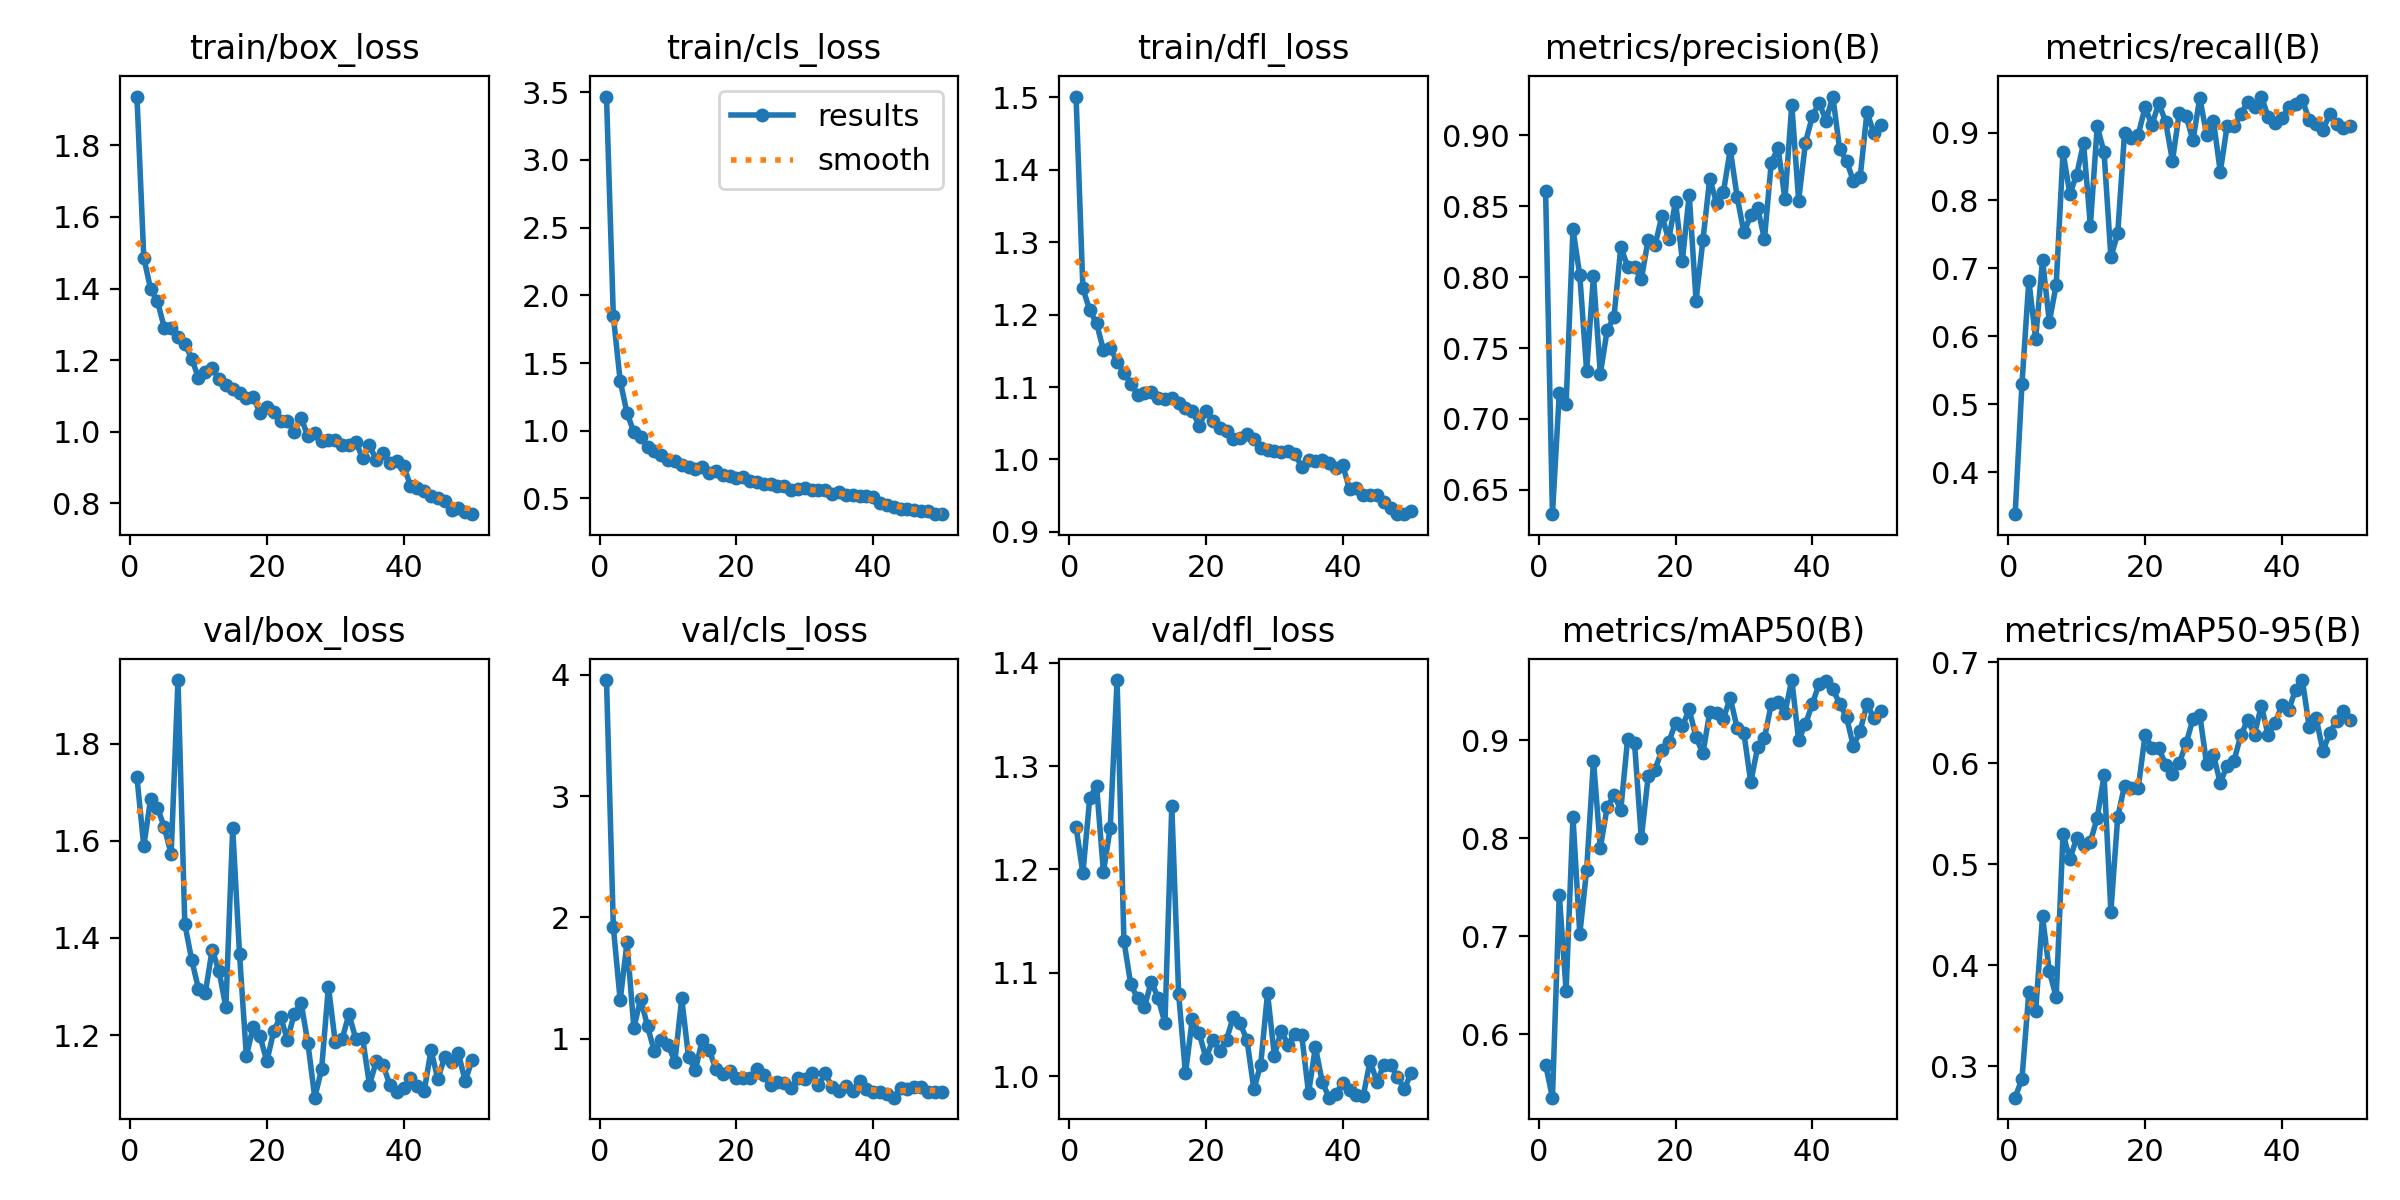

In [16]:
from IPython.display import Image

# Display training results
Image(filename='/content/runs/detect/train/results.png', height=600)

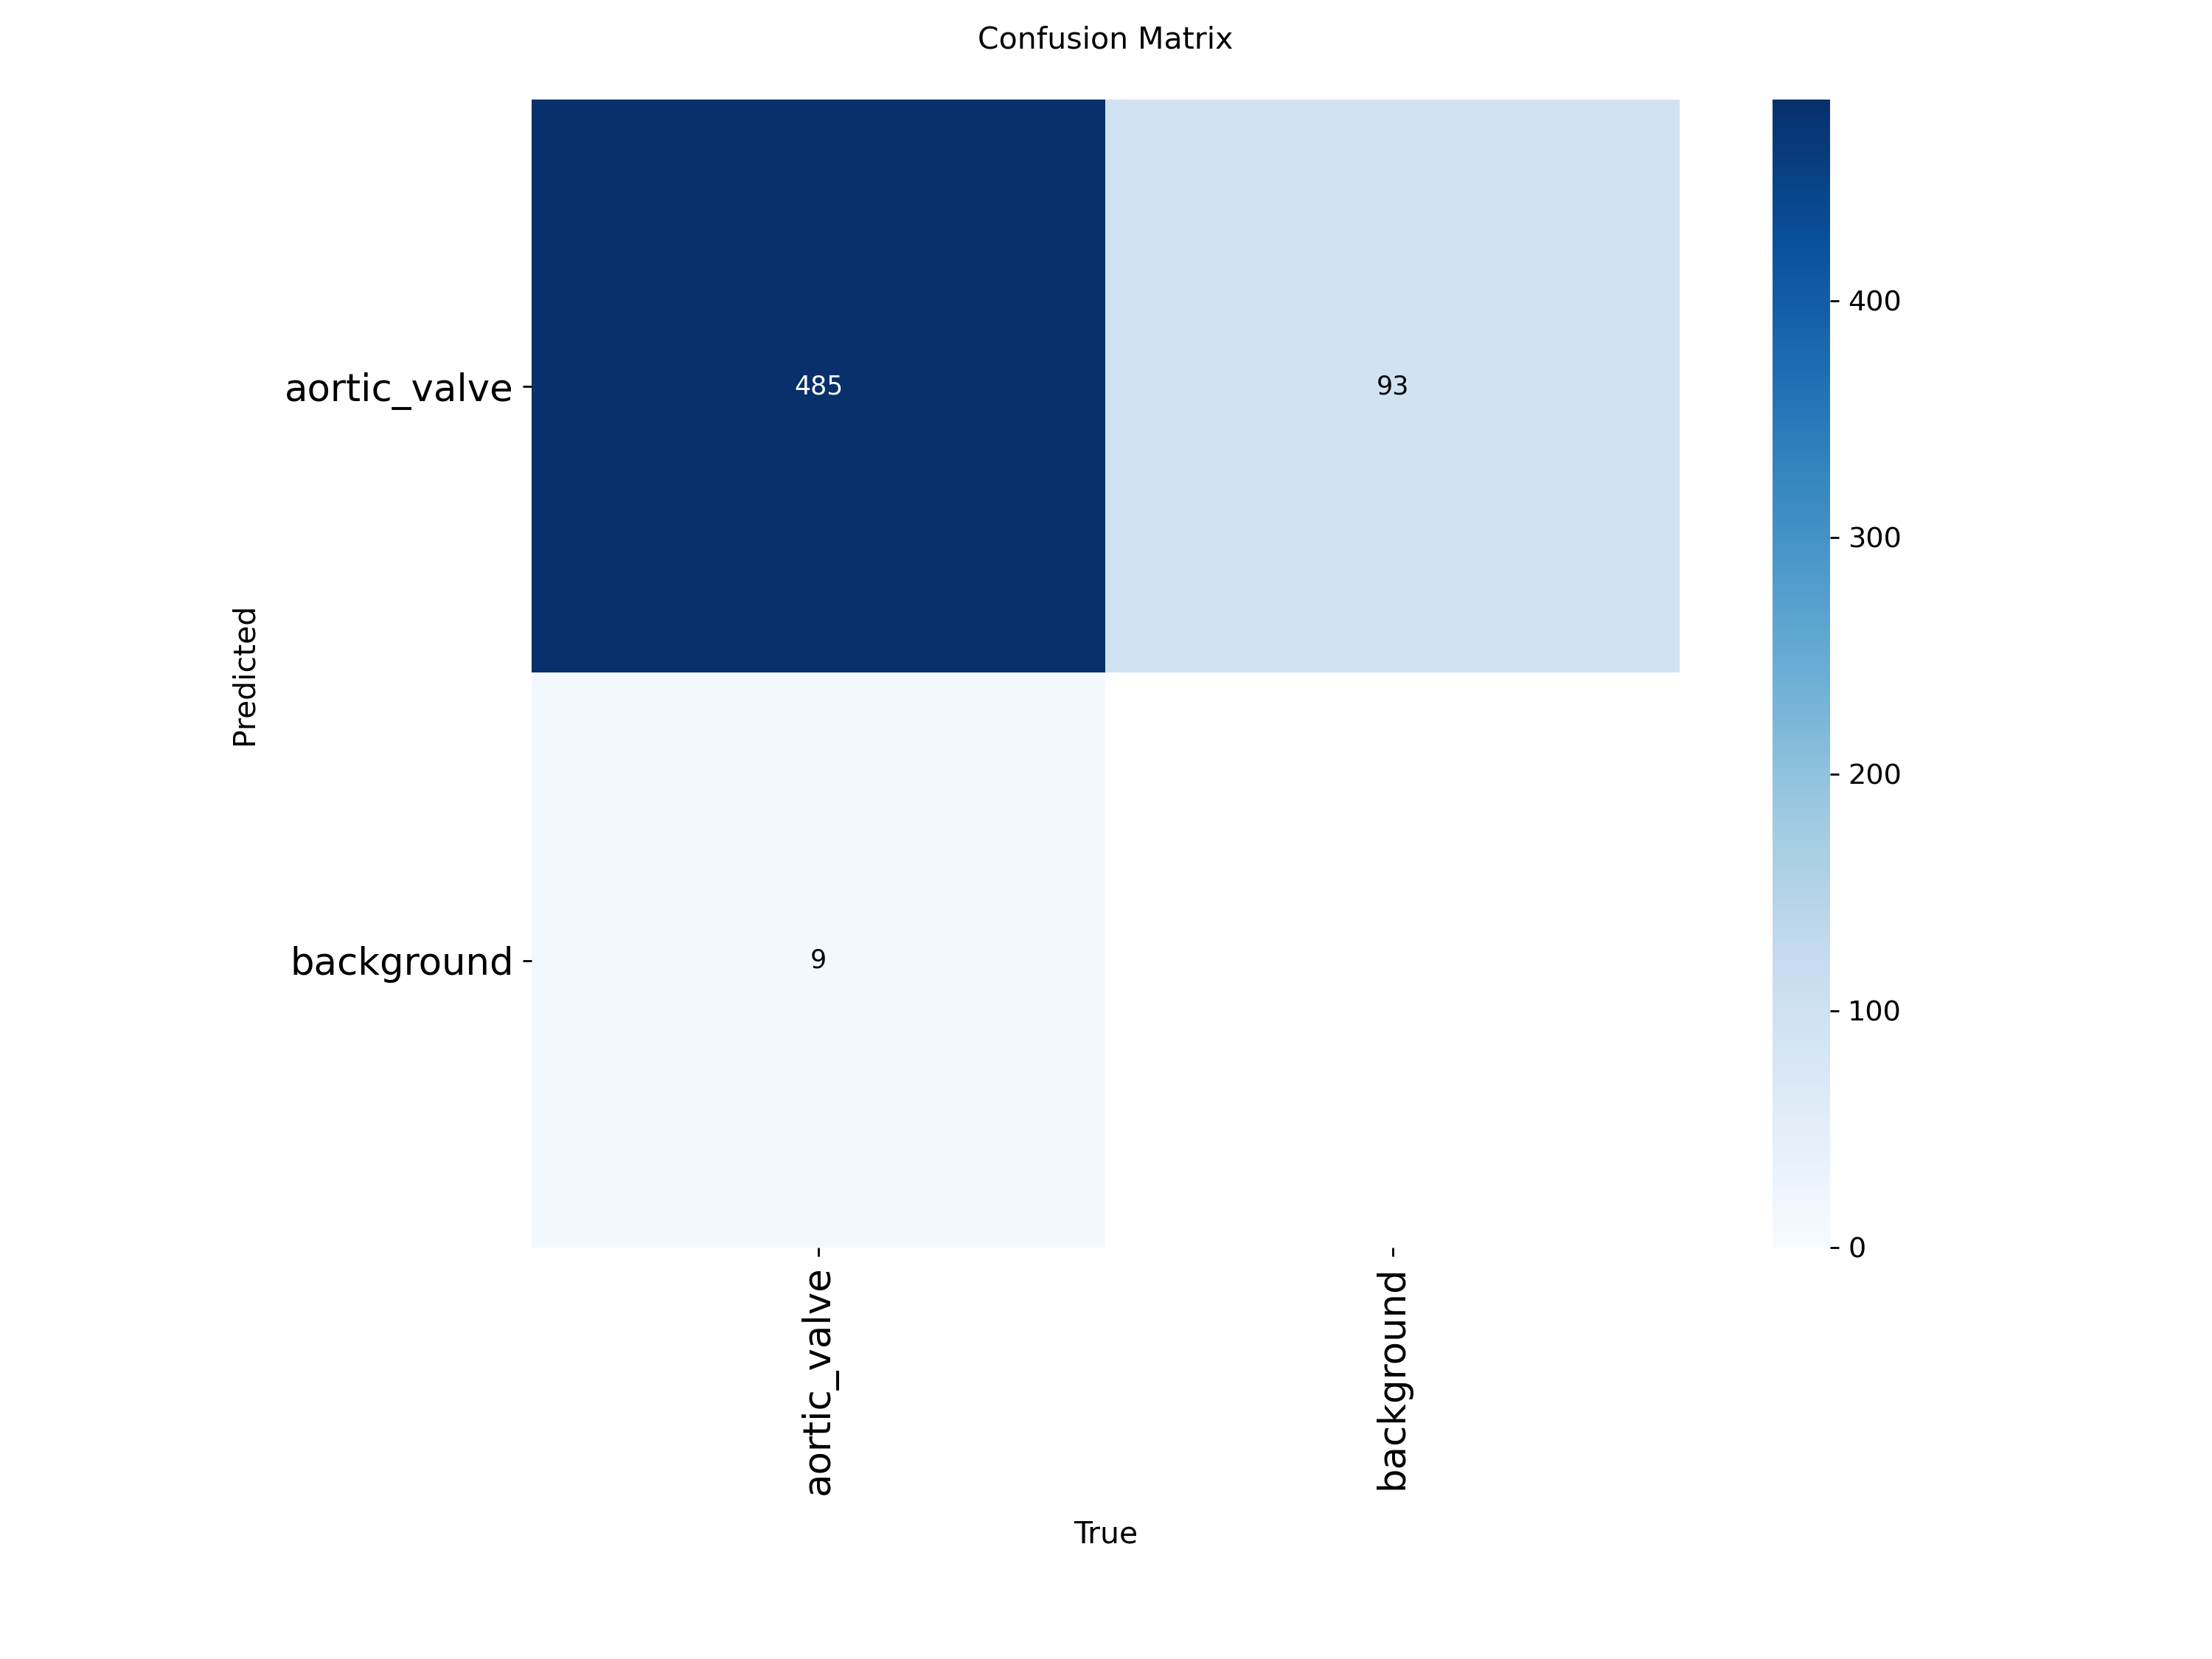

In [17]:
# Display confusion matrix
Image(filename='/content/runs/detect/train/confusion_matrix.png', height=600)